# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

I've select the second environment, which contains 20 identical agents, each with its own copy of the environment.

In [1]:
!pip -q install ./python

from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.19 which is incompatible.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
import random
import torch
import numpy as np
from collections import deque
import time 
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from ddpg_agent_second_env import Agent


The code bellow implements the ddpg algorithm for multiple environments. In addition to the boilerplate implementation in the pendulum environment, the idea is to aggregate the results of the multiple environments and force the agent to learn just after some fixed number of iterations (the was the idea suggested in the benchmark section of the Continuous Control project).

Also I've added some printing to help me track how learning was.

In [3]:
def ddpg(n_episodes=2000, max_t=1000, save_every=20, learn_every=20, num_learn=10, goal_score=30):
    
    overall_scores_deque = deque(maxlen=100)
    overall_scores = []
    time_per_episode = []
    
    print("\nTraining Started. Saving weights every {} episodes".format(save_every))
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]   
        states = env_info.vector_observations 
        scores = np.zeros(20) 
        agent.reset()
        
        t0 = time.time()            
        
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]            
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                                      
            dones = env_info.local_done                         
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done) # map actions to the agents
            
            scores += env_info.rewards                           
            states = next_states                                
            
            if t % learn_every == 0:         
                for _ in range(num_learn):
                    agent.start_learn()
                    
            if np.any(dones):                                   
                break
                
                
        t1 = time.time()
        time_per_episode.append(t1-t0)
            
        mean_score = np.mean(scores)
        overall_scores_deque.append(mean_score)
        overall_scores.append(mean_score)
        overall_average_score = np.mean(overall_scores_deque)
        
        
        print('\rEpisode {}\tOverall Average Score: {:.2f}\tMean: {:.2f}\tTotal Time Per Episode: {:.2f} seconds'.format(i_episode, overall_average_score, mean_score, t1-t0))

        if i_episode % save_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_second_env.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_second_env.pth')
            print('\rSaving Weights in Episode {}\tOverall Average Score: {:.2f}\tMean: {:.2f}\tMean Time Per {} Episodes: {:.2f} seconds'.format(i_episode, overall_average_score, mean_score, save_every,np.mean(time_per_episode[-save_every:])))
            
        if i_episode >= 100 and overall_average_score >= goal_score:
            print('\rEnvironment solved in {} episodes with an Average Score of {:.2f}'.format(i_episode, overall_average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_second_env.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_second_env.pth')
            break
    
    return (scores,overall_scores,overall_average_score,time_per_episode)


In [4]:
agent = Agent(state_size = env_info.vector_observations.shape[1], 
              action_size = brain.vector_action_space_size, 
              random_seed = 42)

scores_res = ddpg(n_episodes=2000, max_t=1000)



Training Started. Saving weights every 20 episodes
Episode 1	Overall Average Score: 0.31	Mean: 0.31	Total Time Per Episode: 9.71 seconds
Episode 2	Overall Average Score: 0.52	Mean: 0.72	Total Time Per Episode: 9.90 seconds
Episode 3	Overall Average Score: 0.69	Mean: 1.03	Total Time Per Episode: 9.92 seconds
Episode 4	Overall Average Score: 0.73	Mean: 0.86	Total Time Per Episode: 9.87 seconds
Episode 5	Overall Average Score: 0.74	Mean: 0.76	Total Time Per Episode: 9.91 seconds
Episode 6	Overall Average Score: 0.79	Mean: 1.06	Total Time Per Episode: 10.03 seconds
Episode 7	Overall Average Score: 0.81	Mean: 0.94	Total Time Per Episode: 10.03 seconds
Episode 8	Overall Average Score: 0.83	Mean: 0.95	Total Time Per Episode: 9.97 seconds
Episode 9	Overall Average Score: 0.84	Mean: 0.90	Total Time Per Episode: 10.06 seconds
Episode 10	Overall Average Score: 0.84	Mean: 0.83	Total Time Per Episode: 10.10 seconds
Episode 11	Overall Average Score: 0.86	Mean: 1.05	Total Time Per Episode: 10.25 sec

Episode 89	Overall Average Score: 11.13	Mean: 36.69	Total Time Per Episode: 14.85 seconds
Episode 90	Overall Average Score: 11.42	Mean: 37.10	Total Time Per Episode: 14.88 seconds
Episode 91	Overall Average Score: 11.70	Mean: 37.24	Total Time Per Episode: 14.87 seconds
Episode 92	Overall Average Score: 11.99	Mean: 38.05	Total Time Per Episode: 14.98 seconds
Episode 93	Overall Average Score: 12.26	Mean: 37.53	Total Time Per Episode: 14.83 seconds
Episode 94	Overall Average Score: 12.53	Mean: 37.14	Total Time Per Episode: 14.82 seconds
Episode 95	Overall Average Score: 12.80	Mean: 38.32	Total Time Per Episode: 14.85 seconds
Episode 96	Overall Average Score: 13.06	Mean: 37.70	Total Time Per Episode: 14.92 seconds
Episode 97	Overall Average Score: 13.30	Mean: 36.72	Total Time Per Episode: 14.93 seconds
Episode 98	Overall Average Score: 13.55	Mean: 38.05	Total Time Per Episode: 14.87 seconds
Episode 99	Overall Average Score: 13.80	Mean: 38.00	Total Time Per Episode: 14.87 seconds
Episode 10

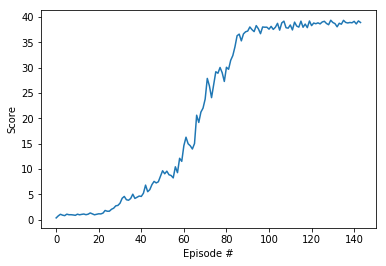

In [12]:
pickle.dump(scores_res, open('second_env_model_results.sav', 'wb'))


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_res[1])), scores_res[1])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()